# TP 1: Comparaison d'algorithmes itératif pour minimiser un modèle de débruitage d'image


Nous allons, lors de ce TP, comparer les performances des algorithmes vus en
cours. Pour cela, nous considérerons un problème de débruitage: notre donnée
est de la forme
\[v=u+b,
\]
où $u\in {\mathbb R}^{N^2}$ est l'image que l'on cherche, $v\in {\mathbb R}^{N^2}$ est la
donnée à notre disposition et $b\in {\mathbb R}^{N^2}$ est la réalisation d'un bruit
blanc Gaussien.

Le modèle que l'on cherchera à résoudre consiste à minimiser l'énergie
$$E(w)=\sum_{i,j=0}^{N-1} |\nabla w_{i,j}|^2 + \lambda \sum_{i,j=0}^{N-1}
(w_{i,j}-v_{i,j})^2,
$$
pour $w\in {\mathbb R}^{N^2}$ et $\lambda \geq 0$, avec
$$\nabla w_{i,j}=\left(\begin{array}{c}
(D_x w)_{i,j} \\
(D_y w)_{i,j}
\end{array}
\right)=\left(\begin{array}{c}
w_{i+1,j}-w_{i,j} \\
w_{i,j+1}-w_{i,j}
\end{array}
\right)
$$
pour $(i,j)\in\{0,\ldots,N-1\}^2$ (on supposera que $w$ est périodisée en
dehors de son support).

Ce TP porte sur le problème étudié dans le TD 1, exercice 2. Les notations (notammment l'opérateur $B$) sont décrites dans cet exercice.




## Chargement de bibliothèques, chargement d'une image et affichage d'une image

In [21]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


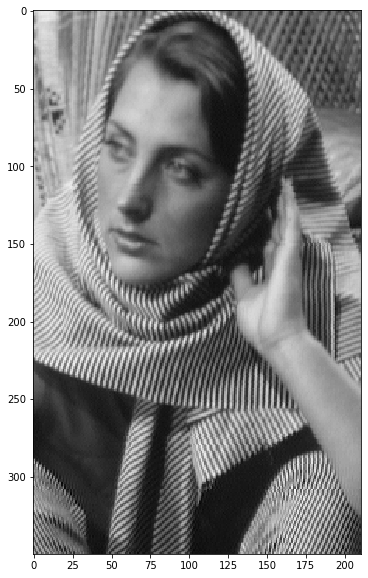

In [11]:
u = 255 * mpimg.imread("barbara.png")
u = u[0:350,300:511]    # image de taille moyenne
#u = u[100:140,300:331]   # Toute petite image pour debugger

plt.figure(figsize = (10,10))
plt.imshow(u,cmap='gray')
plt.show()

## Fonction faisant un calcul exact du minimiseur

In [12]:
def quadratique_exacte(v,Lambda):

    fftV = np.fft.fft2(v)
    fftOut=np.copy(fftV)
   
    sx , sy = np.shape(v)
    for x in range(sx):
        for y in range(sy):
            fftOut[x][y]= Lambda * fftV[x][y]/(Lambda + 4 - 2*(math.cos(2*math.pi*x/sx)+math.cos(2*math.pi*y/sy)))
    
    out =  np.fft.ifft2(fftOut) 
    out = out.real

    return out

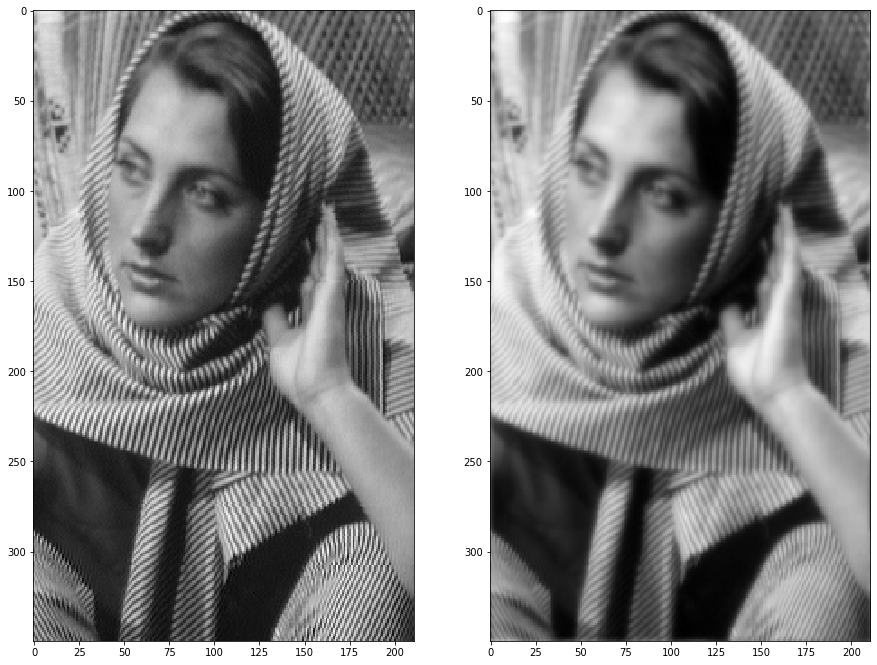

In [13]:
v = u
Lambda=1
out = quadratique_exacte(v,Lambda)

plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out,cmap='gray')



## Fonction calculant itérativement le minimiseur

In [14]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else:
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x

def verifie_grad_x(in1,in2):
    tmp1 = sum(sum(grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def verifie_grad_y(in1,in2):
    tmp1 = sum(sum(grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')

def grad_E(out,v,Lambda):
    tmpx = grad_x(out,0)
    tmpx1 = grad_x(tmpx,1)
    tmpy = grad_y(out,0)
    tmpy1 = grad_y(tmpy,1)
    
    grad = 2 * (tmpx1 + tmpy1 + Lambda * (out-v)) 
    
    return grad

def E(out,v,Lambda):
    sx , sy = np.shape(out)
    gx = np.linalg.norm( grad_x(out,0), ord='fro')
    gy = np.linalg.norm( grad_y(out,0), ord='fro')
    data = np.linalg.norm( out - v , ord='fro')
    
    return (gx*gx + gy*gy + Lambda *data*data)/(sx*sy)

def quadratique_approx(v,Lambda,nbIter):
    pas = 0.05
    out_exacte = quadratique_exacte(v,Lambda)
    out = np.copy(v)                # initialisation proche de la solution
#    out = np.zeros(np.shape(v))    # initialisation plus lointaine (pour tester)
#    out = out_exacte               # initialisation proche sur la solution (pour tester)
    
    for it in range(nbIter):
        d = grad_E(out,v,Lambda)
        out = out - pas * d
        print( 'iter = ', it , 'fonction = ' , E(out,v,Lambda), 'norm grad =',\
               np.linalg.norm(d), 'distance a la solution = ', np.linalg.norm(out-out_exacte)  )
        
    return out

-52264.681179881096  =  -52264.681179878105  ?
-31605236.0  =  -31605236.0  ?
85318.55174975138  =  85318.55174975138  ?
-10139786.0  =  -10139786.0  ?


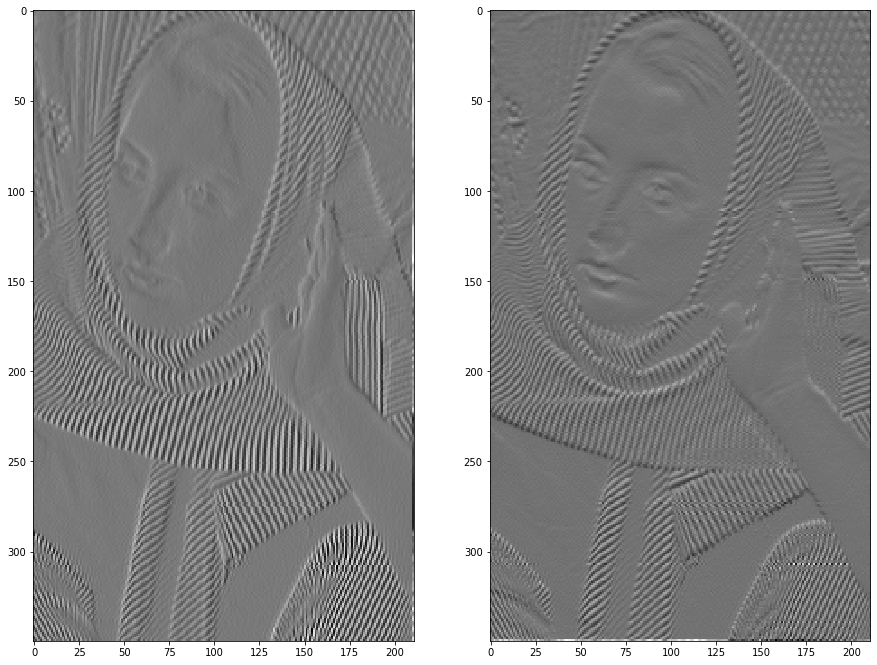

In [15]:
# Debug les differences finies
v = u
verifie_grad_y(u,np.random.normal(100,10,np.shape(u)))
verifie_grad_y(u,v)
dy = grad_y(v, 0)

verifie_grad_x(u,np.random.normal(100,10,np.shape(u)))
verifie_grad_x(u,v)
dx= grad_x(v, 0)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(dy,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dx,cmap='gray')




In [16]:
def fast_grad_x(img, adjoint):

    sx , sy = np.shape(img)
    tmp=np.zeros(img.shape)
    if adjoint==0:
        tmp[-1]=img[0]
        tmp[:-1]=img[1:]
    else:
        tmp[0]=img[-1]
        tmp[1:]=img[:-1]
    return tmp-img

def verifie_fast_grad_x(in1,in2):
    tmp1 = sum(sum(fast_grad_x(in1, 0) * in2))
    tmp2 = sum(sum(in1 * fast_grad_x(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')
    
    return tmp1==tmp2
    
def fast_grad_y(img, adjoint):
    tmp=np.zeros(img.shape)
    if adjoint==0:
        tmp[:,-1]=img[:,0]
        tmp[:,:-1]=img[:,1:]
    else:
        tmp[:,0]=img[:,-1]
        tmp[:,1:]=img[:,:-1]
    return tmp-img

def verifie_fast_grad_y(in1,in2):
    tmp1 = sum(sum(fast_grad_y(in1, 0) * in2))
    tmp2 = sum(sum(in1 * fast_grad_y(in2, 1)))
    print(tmp1, ' = ', tmp2,' ?')


24266.223544566194  =  24266.223544566696  ?
-31605236.0  =  -31605236.0  ?
-451.3648851541234  =  -451.3648851540896  ?
-10139786.0  =  -10139786.0  ?


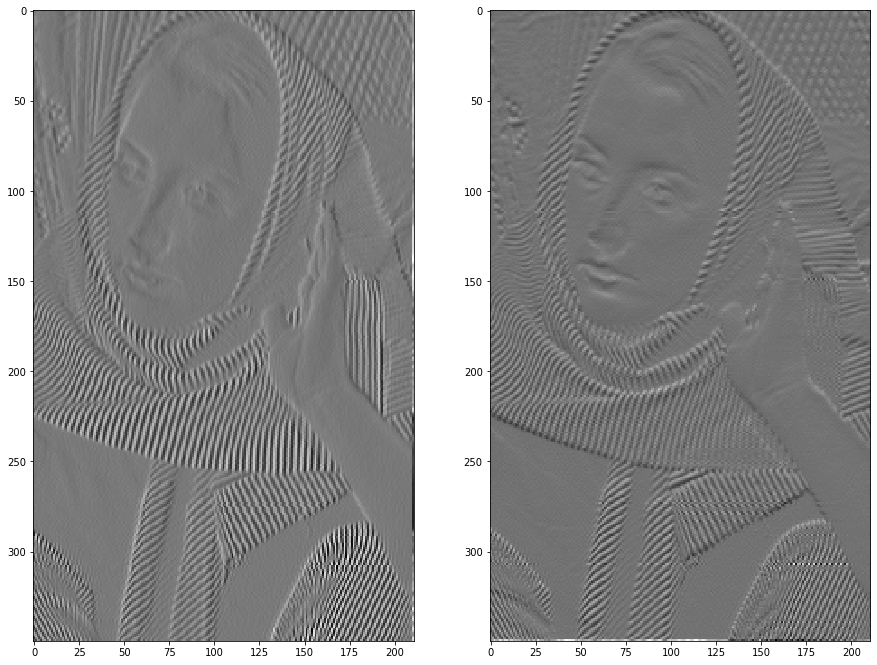

In [20]:
# Debug les differences finies rapides
v = u
verifie_fast_grad_y(u,np.random.normal(100,10,np.shape(u)))
verifie_fast_grad_y(u,v)
dy = fast_grad_y(v, 0)

verifie_fast_grad_x(u,np.random.normal(100,10,np.shape(u)))
verifie_fast_grad_x(u,v)
dx= fast_grad_x(v, 0)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(dy,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(dx,cmap='gray')


iter =  0 fonction =  626.9959940163883 norm grad = 30919.03 distance a la solution =  2484.4177
iter =  1 fonction =  458.7550017756938 norm grad = 17608.83 distance a la solution =  1664.4332
iter =  2 fonction =  394.91420746552114 norm grad = 10750.254 distance a la solution =  1169.1906
iter =  3 fonction =  368.53716128743815 norm grad = 6858.9414 distance a la solution =  857.49475
iter =  4 fonction =  356.812344543042 norm grad = 4541.0312 distance a la solution =  653.5407
iter =  5 fonction =  351.2260712208043 norm grad = 3112.6418 distance a la solution =  514.56573
iter =  6 fonction =  348.37654454216414 norm grad = 2207.5247 distance a la solution =  415.82556
iter =  7 fonction =  346.8228299753716 norm grad = 1618.8475 distance a la solution =  342.78357
iter =  8 fonction =  345.92117922866515 norm grad = 1225.426 distance a la solution =  286.77487
iter =  9 fonction =  345.36798747612886 norm grad = 954.51385 distance a la solution =  242.52972
iter =  10 fonction 

iter =  83 fonction =  344.18137467704275 norm grad = 0.068868525 distance a la solution =  0.028871682
iter =  84 fonction =  344.1813859418767 norm grad = 0.061776835 distance a la solution =  0.025980033
iter =  85 fonction =  344.1814242886399 norm grad = 0.055495016 distance a la solution =  0.023427527
iter =  86 fonction =  344.18140960962046 norm grad = 0.049946953 distance a la solution =  0.02117475
iter =  87 fonction =  344.18143441543197 norm grad = 0.045042437 distance a la solution =  0.019203184
iter =  88 fonction =  344.1814332773787 norm grad = 0.04074357 distance a la solution =  0.017487083
iter =  89 fonction =  344.18141859836567 norm grad = 0.036984473 distance a la solution =  0.015995596
iter =  90 fonction =  344.1814050574043 norm grad = 0.033731278 distance a la solution =  0.014719232
iter =  91 fonction =  344.1814310012771 norm grad = 0.030922817 distance a la solution =  0.013642356
iter =  92 fonction =  344.1814298632287 norm grad = 0.028551634 distan

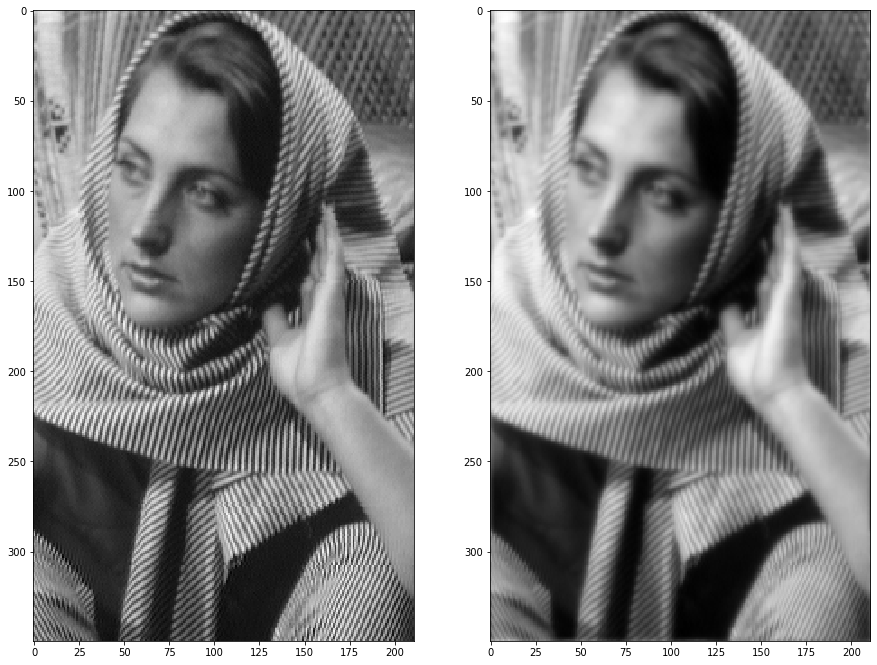

In [56]:
v=u
Lambda=1
out = quadratique_approx(v,Lambda,100)


plt.figure(figsize = (15,30))
plt.subplot(1,2,1)
plt.imshow(u,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(out,cmap='gray')